In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from flowpm.cosmology import Planck15
import numpy as np
import flowpm
from flowpm.utils import r2c2d, c2r2d
from flowpm.tfpower import linear_matter_power

In [2]:
# Below are a few parameters
n_lens = 22       # Number of lensplanes in the lightcone
box_size = 100.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel

In [3]:
# Instantiates a cosmology with desired parameters
cosmology = Planck15()

In [4]:
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1]) # the position of each lens plans 

# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)

In [5]:
# this should be the redshift of our last lens
1/a[-1] - 1

<tf.Tensor: shape=(), dtype=float32, numpy=0.94021237>

In [6]:
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [7]:
# Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [8]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 

In [9]:
states[::-1][0][1][0]
#we have a list with 25 states
#[::-1]= invert the list ; 
# [0] take the first state of this reversed list( corresponds a_center=0.9832467)
#in each state we have a list of 2 elements, the a_center value and the physical features of the particles
#[1] take the second list, that describes the physical properties of each particles 
#we have now a tensor with shape=(3, 1, 2097152, 3)
#[0] take the position of each particales, for x,y,z

<tf.Tensor: shape=(1, 2097152, 3), dtype=float32, numpy=
array([[[  8.540628  ,   2.237082  ,  -2.9626389 ],
        [  8.77851   ,   2.0792654 ,  -1.2520798 ],
        [  9.029757  ,   2.22836   ,  -0.38430706],
        ...,
        [135.07584   , 128.6731    , 123.277336  ],
        [136.16336   , 128.92258   , 124.21646   ],
        [136.43802   , 129.2595    , 124.683304  ]]], dtype=float32)>

In [88]:
def generate_matrix(
    di,
    df,
    ds,
    boxsize,

):

    # Generate the possible rotation matrices
    x = np.asarray([1, 0, 0], dtype=int)
    y = np.asarray([0, 1, 0], dtype=int)
    z = np.asarray([0, 0, 1], dtype=int)

    # shuffle directions, only 90 deg rotations, makes a total of 6
    M_matrices = [np.asarray([x,y,z],dtype=int), np.asarray([x,z,y],dtype=int),np.asarray([z,y,x],dtype=int),np.asarray([z,x,y],dtype=int), \
                       np.asarray([y,x,z],dtype=int), np.asarray([y,z,x],dtype=int)]
    # Generate possible xy shifts
    I = np.zeros(3)
    shift_ini = np.floor(max(di, ds) / boxsize[-1])
    shift_end = np.floor(df / boxsize[-1])
    M = []
    for ii in np.arange(shift_end, shift_ini + 1, dtype=int):
        facz = np.random.uniform(0,1)
        fac = np.random.uniform(0,1)
        #fac=np.random.randint(0,256)
        xyshifts = [
          np.asarray([fac, fac, facz], dtype=float),
          np.asarray([-fac, fac, -facz], dtype=float),
          np.asarray([-fac, -fac, -facz], dtype=float),
          np.asarray([fac, -fac, facz], dtype=float)
        ]
        for jj in range(4):
              M.append(
                  (M_matrices[ii % len(M_matrices)], I + xyshifts[jj]))
    return M

In [89]:
def density_plane(state,
                  nc,
                  center,
                  Matrix,
                  width,
                  plane_resolution,
                  name='density_plane'):
  """ Extract a slice from the input state vector and
  project it as a density plane.

  Args:
    state: `Tensor`, input state tensor.
    nc: int or list of int, size of simulation volume
    center: float, center of the slice along the z axis in voxel coordinates
    width: float, width of the slice in voxel coordinates
    plane_size: int, number of pixels of the density plane. 
    name: `string`, name of the operation.

  Returns:
    `Tensor` of shape [batch_size, plane_size, plane_size], of projected density plane.
  """
  with tf.name_scope(name):
    state = tf.convert_to_tensor(state, name="state")
    if isinstance(nc, int):
      nc = [nc, nc, nc]
    nx, ny, nz = nc
    pos = state[0]

    shape = tf.shape(pos)
    batch_size = shape[0]
    y = tf.einsum('ij,kj->ki', Matrix[0], pos[0])  #states[::-1][i][1] 
    y = tf.add(y, [100.,100.,100.] * Matrix[1])
    d = tf.gather(y, 2, axis=1, name='gather_z')
    xy = tf.gather(y, (0, 1), axis=1, name='gather_xy')
    xy=tf.expand_dims(xy, axis=0)
    d=tf.expand_dims(d, axis=0)
    
    

    # Apply 2d periodic conditions
    xy = tf.math.mod(xy, nx)

    # Rescaling positions to target grid
    xy = xy / nx * plane_resolution

    # Selecting only particles that fall inside the volume of interest
    mask = (d > (center - width / 2)) & (d <= (center + width / 2))

    # Painting density plane
    density_plane = tf.zeros([batch_size, plane_resolution, plane_resolution])
    density_plane = flowpm.utils.cic_paint_2d(density_plane, xy, mask=mask)

    # Apply density normalization
    density_plane = density_plane / ((nx / plane_resolution) *
                                     (ny / plane_resolution) * (width))

    return density_plane

In [96]:
M=generate_matrix(
    r[-1],
    r[0],
    r[-1],
    [100.,100.,100.],

)

In [97]:
lensplanes = []
for i in range(len(a_center)):
    plane = density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            M[i],
                                            width=nc,
                                            plane_resolution=256)
    
    plane = tf.expand_dims(plane, axis=-1)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))

In [98]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [99]:
z_source = tf.linspace(0.5, 1, 4)

In [100]:
m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix, -1])

Populating the interactive namespace from numpy and matplotlib


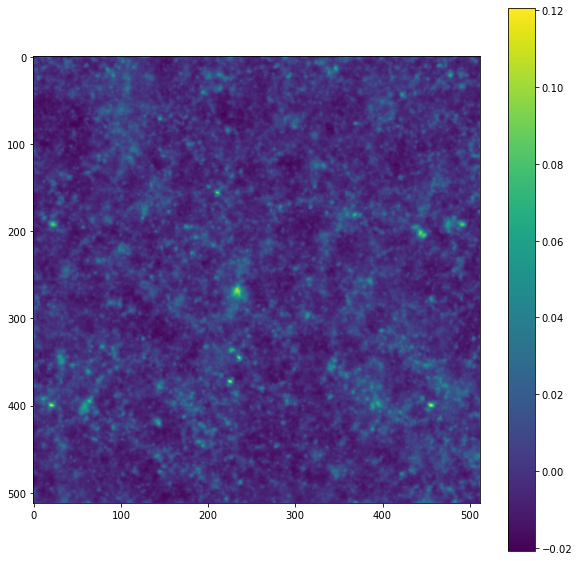

In [101]:
%pylab inline 
figure(figsize=[10,10])
imshow(m[0,:,:,-1]); colorbar();

In [37]:
# Extract the lensplanes
lensplanes1 = []
for i in range(len(a_center)):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            width=nc,
                                            plane_resolution=256)
    plane = tf.roll(plane, shift=np.random.randint(0,256), axis=1)
    plane = tf.roll(plane, shift=np.random.randint(0,256), axis=2)
    plane = tf.expand_dims(plane, axis=-1)
    plane = tf.image.random_flip_left_right(plane)
    plane = tf.image.random_flip_up_down(plane)
    lensplanes1.append((r_center[i], states[::-1][i][0], plane[...,0]))

In [38]:
m1 = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes1, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m1 = m1.numpy().reshape([batch_size, field_npix, field_npix, -1])

Populating the interactive namespace from numpy and matplotlib


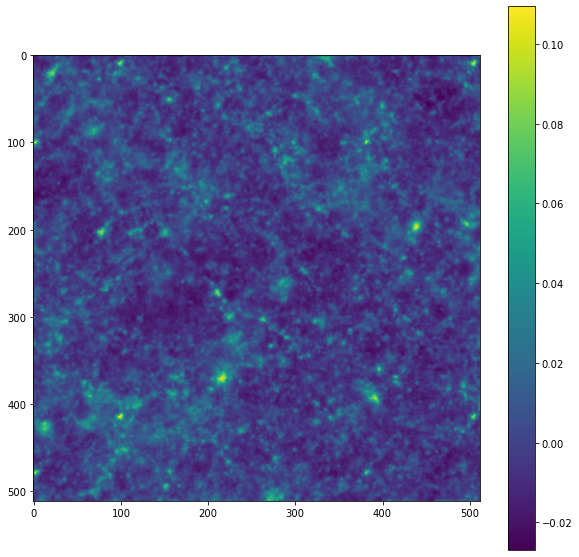

In [39]:
%pylab inline 
figure(figsize=[10,10])
imshow(m1[0,:,:,-1]); colorbar();